<a href="https://colab.research.google.com/github/pphos/pytorch_tutorial/blob/master/cifar10_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Classifier

ニューラルネットワークを定義し, 損失を計算し, ネットワークの重みを更新する方法を見てきました.

今あなたは考えているかもしれません...

### データについてはどうなんだ？
一般に, 画像, テキスト, オーディオ, またはビデオデータを処理する必要がある場合には, numpy配列にデータをロードする標準的なPythonパッケージを使用できます. そしてこの配列を`torch.*Tensor`に変換できます.

- 画像の場合, Pillow, OpenCVなどのパッケージが役立ちます
- オーディオの場合, scipyやlibrosaなどのパッケージが役立ちます
- テキストの場合, 未加工のPythonまたはCythonベースのロードやNLTKとSpaCyのいずれかが役立ちます.

特にビジョンについては, Imagenet, CIFAR10, MNISTなどの一般的なデータセット用のデータローダと, 画像, つまり`torchvision.datasets`と`torch.utils.data.DataLoader`のデータトランスフォーマを備えた`torchvision`というパッケージを作成しました.

これにより非常に便利になり, 定型コードを書く必要がなくなります.

このチュートリアルでは, CIFAR10データセットを使用します.
クラスには「飛行機」,「自動車」,「鳥」,「猫」,「鹿」,「犬」,「カエル」,「馬」,「船」,「トラック」があります.
CIFAR10の画像サイズは3x32x32つまり, 32x32ピクセルのカラーチャネル画像です.

## Training an image classifier

次の手順を順番に実行します:
1. `torchvison`を使用してCIFAR10の訓練データおよびテストデータを読み込み, 正規化します.
2. Convolutional Neural Networkを定義します.
3. 損失関数を定義します.
4. 訓練データを用いてネットワークを訓練します.
5. テストデータを用いてネットワークを評価します.

### 1. CIFAR10の読み込みおよび正規化
`torchvision`を用いてCIFAR10データセットを読み込みます.




In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvisionデータセットの出力は, [0,1]のPILImage画像です.
それらを[-1, 1]の範囲で正規化されたテンソルに変換します.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


いくつかの訓練画像を表示しましょう

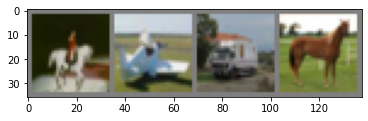

horse plane truck horse


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. Define a Convolutional Neural Network
以前のニューラルネットワークセクションからニューラルネットワークをコピーし, 3チャネルの画像を取得するように変更します.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()

### 3. Define a Loss function and optimizer
Categorical Cross-EntropyとSGDを使いましょう

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network
ここからが面白いところです.
単純にデータイテレータをループさせて, 入力をネットワークに送り, 最適化するだけです.

In [6]:
for epoch in range(2):

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.138
[1,  4000] loss: 1.815
[1,  6000] loss: 1.680
[1,  8000] loss: 1.572
[1, 10000] loss: 1.525
[1, 12000] loss: 1.468
[2,  2000] loss: 1.405
[2,  4000] loss: 1.391
[2,  6000] loss: 1.364
[2,  8000] loss: 1.334
[2, 10000] loss: 1.317
[2, 12000] loss: 1.298
Finished Training


### 5. Test the network on the test data
学習データ・セットで2パスのネットワークを訓練しました.
しかし, ネットワークが何かを学んだかを確認する必要があります.

ニューラルネットワークが出力するクラスラベルを予測し, それを正解データと照らし合わせて確認します.
予測が正しければ, そのサンプルを正しい予測リストに追加します.

さて, 最初のステップとして, テストデータセットの画像を表示しましょう.

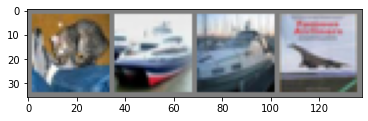

GroundTruth:    cat  ship  ship plane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

さて, ニューラルネットワークが上記の例をどう考えているかを見てみましょう.

In [0]:
outputs = net(images)

出力は10クラスの確率です.
クラスの確率が高ければ高いほど, ネットワークはその画像が特定のクラスのものであると考えます.
そこで, 最も高い確率のクラスのインデックスを取得してみましょう.

In [10]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car  ship  ship


テスト結果はよいように見えます.
データセット全体でのネットワークの性能を確認しましょう.

In [15]:
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    output = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 9 %


In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('Accuracy of %5s : %2s %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 39.0 %
Accuracy of   car : 73.6 %
Accuracy of  bird : 39.8 %
Accuracy of   cat : 32.0 %
Accuracy of  deer : 34.4 %
Accuracy of   dog : 39.3 %
Accuracy of  frog : 83.7 %
Accuracy of horse : 67.0 %
Accuracy of  ship : 67.9 %
Accuracy of truck : 55.7 %
